# DATA LOADING

In [2]:
import pandas as pd
import numpy as np
from random_forest_scratch import RandomForestScratch
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

DATA_PATH = "earthquake_1995-2023.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)
alert_mapping = {
    'none': 0,
    'green': 1,
    'yellow': 2,
    'orange': 3,
    'red': 4
}

df['alert_encoded'] = df['alert'].fillna('none').map(alert_mapping)
df_clean = df.select_dtypes(include=[np.number])

X = df_clean.drop('tsunami', axis=1).values
y = df_clean['tsunami'].values

print(f"Data loaded. Shape of X: {X.shape}, Shape of y: {y.shape}")

Data loaded. Shape of X: (1000, 11), Shape of y: (1000,)


# RANDOM FOREST FROM SCRATCH IMPLEMENTATION (Classification)

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics_storage = {
    'Accuracy': [],
    'Precision': [],
    'Recall (Sensitivity)': [],
    'F-Measure': [],
    'AUC (ROC)': [],
    'AUPRC': []
}

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = RandomForestScratch(
        n_trees=best_params['n_trees'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split']
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_prob(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if len(np.unique(y_test)) > 1:
        auc = roc_auc_score(y_test, y_prob)
        auprc = average_precision_score(y_test, y_prob)
    else:
        auc = 0.0
        auprc = 0.0

    metrics_storage['Accuracy'].append(acc)
    metrics_storage['Precision'].append(prec)
    metrics_storage['Recall (Sensitivity)'].append(rec)
    metrics_storage['F-Measure'].append(f1)
    metrics_storage['AUC (ROC)'].append(auc)
    metrics_storage['AUPRC'].append(auprc)
    print(f"Fold {fold+1}: Acc={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")


Fold 1: Acc=0.910 | F1=0.866 | AUC=0.956
Fold 2: Acc=0.935 | F1=0.917 | AUC=0.976
Fold 3: Acc=0.915 | F1=0.879 | AUC=0.967
Fold 4: Acc=0.945 | F1=0.909 | AUC=0.983
Fold 5: Acc=0.910 | F1=0.852 | AUC=0.960


# Statystical analysis and summary table for the scratch implementation

In [4]:
print("\n" + "=" * 60)
print(f"{'Metric':<25} | {'Mean':<10} | {'Std Dev':<10}")
print("=" * 60)

results_summary = {}

for metric, values in metrics_storage.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    results_summary[metric] = (mean_val, std_val)

    print(f"{metric:<25} | {mean_val:.4f}     | +/- {std_val:.4f}")

print("="*60)


Metric                    | Mean       | Std Dev   
Accuracy                  | 0.9230     | +/- 0.0144
Precision                 | 0.8538     | +/- 0.0438
Recall (Sensitivity)      | 0.9200     | +/- 0.0252
F-Measure                 | 0.8848     | +/- 0.0248
AUC (ROC)                 | 0.9682     | +/- 0.0100
AUPRC                     | 0.9014     | +/- 0.0351


# LIBRARY IMPLEMENTATION (Scikit-Learn) & COMPARISON

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5]
}

rf_library = RandomForestClassifier(random_state=5)
grid_search = GridSearchCV(estimator=rf_library, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

best_rf_library = grid_search.best_estimator_
print(f"Best Library Params: {grid_search.best_params_}")

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

library_results = cross_validate(best_rf_library, X, y, cv=kf, scoring=scoring_metrics)

print("\n" + "=" * 60)
print(f"{'Metric (Library)':<25} | {'Mean':<10} | {'Std Dev':<10}")
print("=" * 60)

print(
    f"{'Accuracy':<25} | {library_results['test_accuracy'].mean():.4f}     | +/- {library_results['test_accuracy'].std():.4f}")
print(
    f"{'Precision':<25} | {library_results['test_precision'].mean():.4f}     | +/- {library_results['test_precision'].std():.4f}")
print(
    f"{'Recall':<25} | {library_results['test_recall'].mean():.4f}     | +/- {library_results['test_recall'].std():.4f}")
print(f"{'F1-Measure':<25} | {library_results['test_f1'].mean():.4f}     | +/- {library_results['test_f1'].std():.4f}")
print(f"{'AUC (ROC)':<25} | {library_results['test_roc_auc'].mean():.4f}     | +/- {library_results['test_roc_auc'].std():.4f}")
print("="*60)

Best Library Params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}

Metric (Library)          | Mean       | Std Dev   
Accuracy                  | 0.9350     | +/- 0.0089
Precision                 | 0.8499     | +/- 0.0332
Recall                    | 0.9707     | +/- 0.0264
F1-Measure                | 0.9055     | +/- 0.0171
AUC (ROC)                 | 0.9729     | +/- 0.0075


# INTERPRETABILITY (SHAP) FOR SCRATCH MODEL

  0%|          | 0/100 [00:00<?, ?it/s]

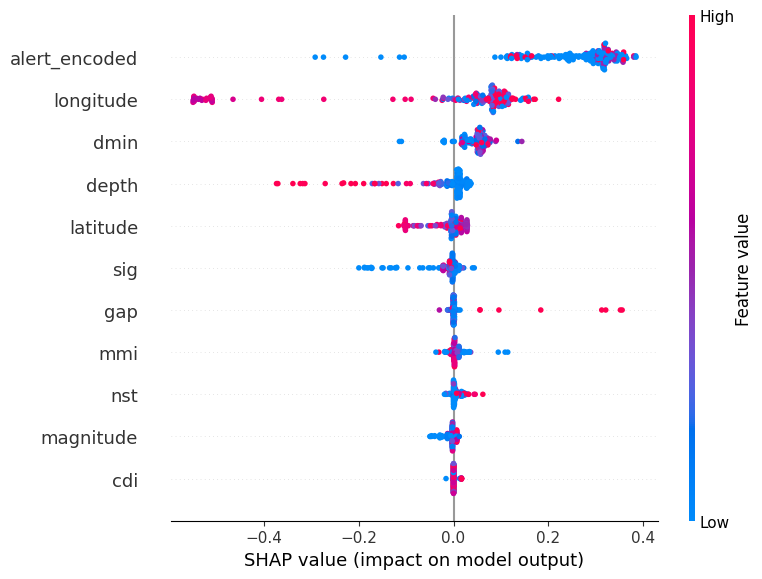

  0%|          | 0/200 [00:00<?, ?it/s]

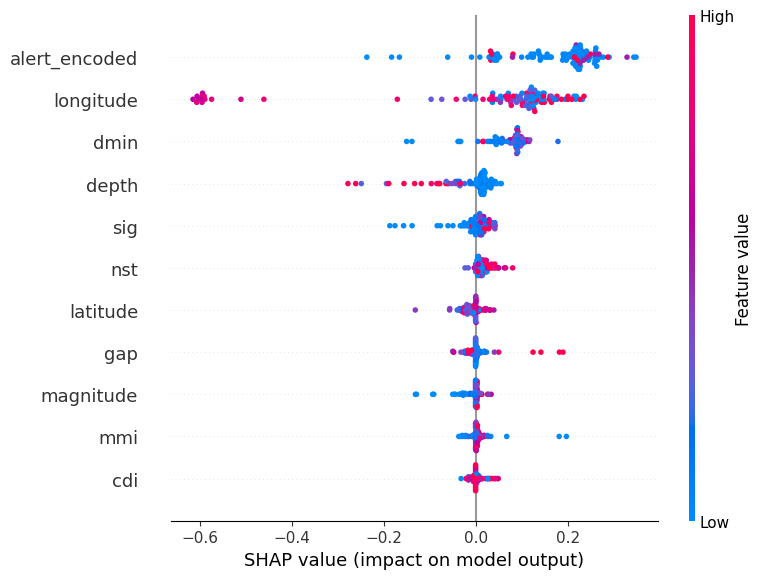

In [ ]:
import shap
import matplotlib.pyplot as plt

background_data = shap.kmeans(X, 50)
explainer = shap.KernelExplainer(clf.predict_prob, background_data)

X_explain = X[:100]
shap_values = explainer.shap_values(X_explain)

feature_names = df_clean.drop('tsunami', axis=1).columns.tolist()

shap.summary_plot(shap_values, X_explain, feature_names=feature_names)